# Metro Interstate Traffic Volume

### Dataset: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

1. holiday Categorical US National holidays plus regional holiday, Minnesota State Fair 
2. temp Numeric Average temp in kelvin 
3. rain_1h Numeric Amount in mm of rain that occurred in the hour 
4. snow_1h Numeric Amount in mm of snow that occurred in the hour 
5. clouds_all Numeric Percentage of cloud cover 
6. weather_main Categorical Short textual description of the current weather 
7. weather_description Categorical Longer textual description of the current weather 
8. date_time DateTime Hour of the data collected in local CST time 
9. traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [ ]:
#Import necessary libraries
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import scatter_matrix
import seaborn as sns

#Creating pipeline to transform data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Importing dataset from csv to data frame
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz")

In [ ]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
df.shape

(48204, 9)

No null value is present in the data.

In [ ]:
df.date_time.max(), df.date_time.min()

('2018-09-30 23:00:00', '2012-10-02 09:00:00')

### Univariate Analysis

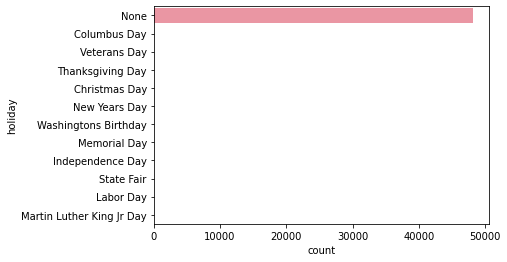

In [ ]:
sns.countplot(y='holiday', data=df)
#plt.tight_layout()
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/holiday.png')

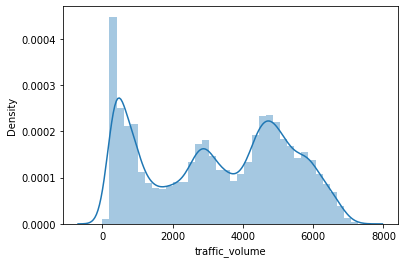

In [ ]:
sns.distplot(df.traffic_volume)

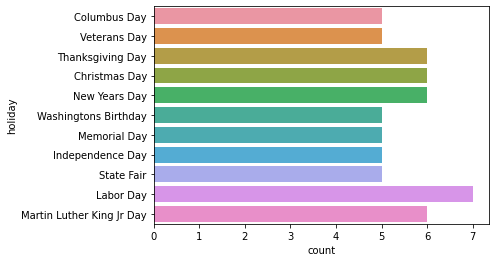

In [ ]:
holidays = df.loc[df.holiday != 'None']
sns.countplot(y='holiday', data= holidays)
#plt.tight_layout()
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/other_holiday.png')

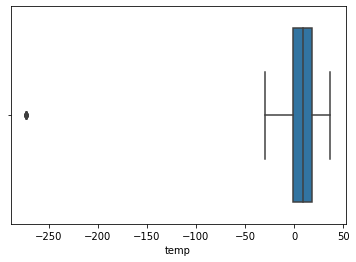

In [ ]:
sns.boxplot('temp', data = df)
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/temp_before.png')

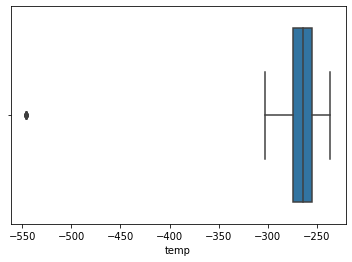

In [ ]:
#kelvin -> celcius 
df['temp'] = (df['temp']-273.15) 
sns.boxplot('temp', data = df)
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/temp_after.png')

There is one data point far away from the rest around -300 degrees celsius. Clearly, this is an error in recording. This needs to be eliminated in the data cleaning phase.

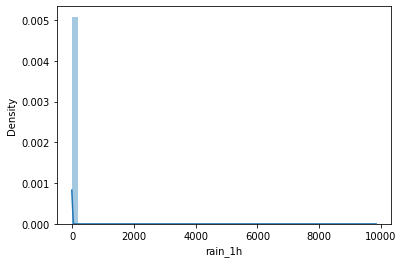

In [ ]:
sns.distplot(df.rain_1h)
plt.show()

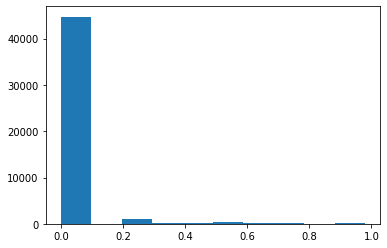

In [ ]:
plt.hist(df.rain_1h.loc[df.rain_1h<1])
plt.show()

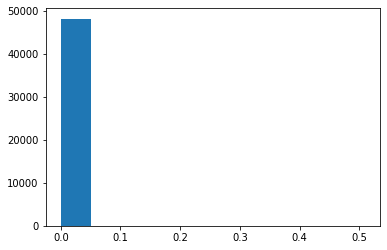

In [ ]:
plt.hist(df.snow_1h)
plt.show()

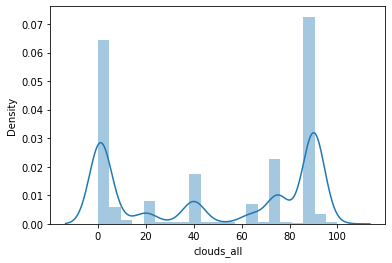

In [ ]:
sns.distplot(df.clouds_all)
plt.show()

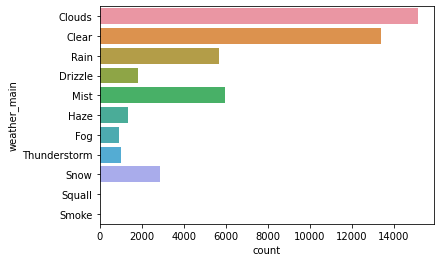

In [ ]:
sns.countplot(y='weather_main', data=df)
#plt.tight_layout()
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/weather.png')

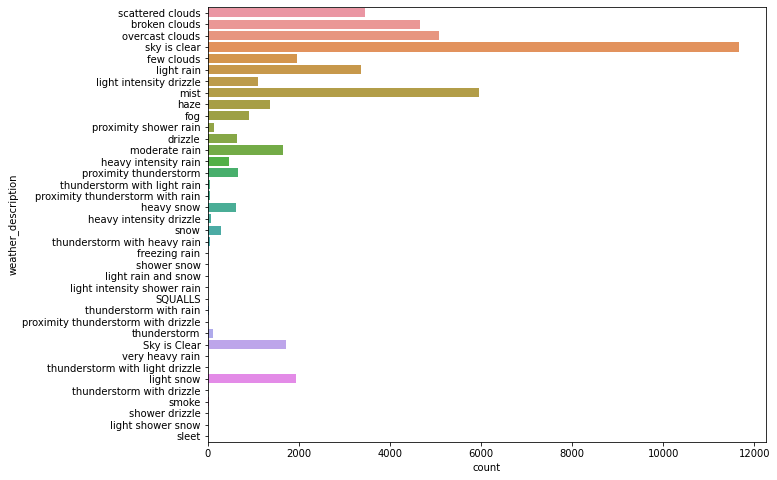

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(y='weather_description', data=df)
#plt.tight_layout()
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/weather_description.png')

### Bivariate Analysis

Exploring relationship between traffic and other features

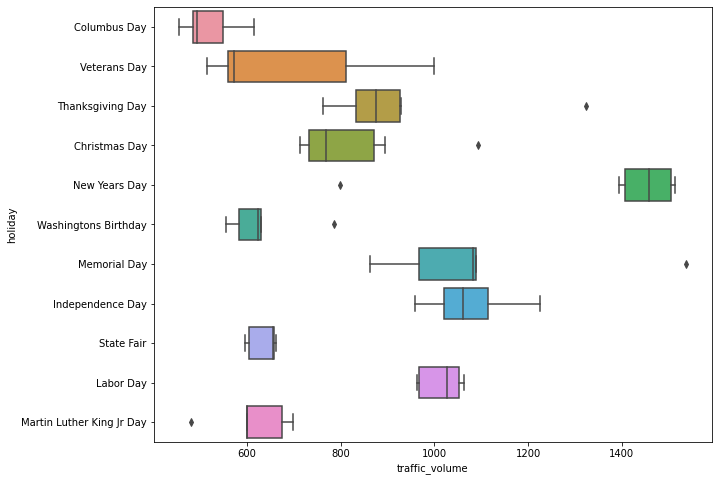

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(y='holiday',x='traffic_volume', data = holidays)
plt.show()

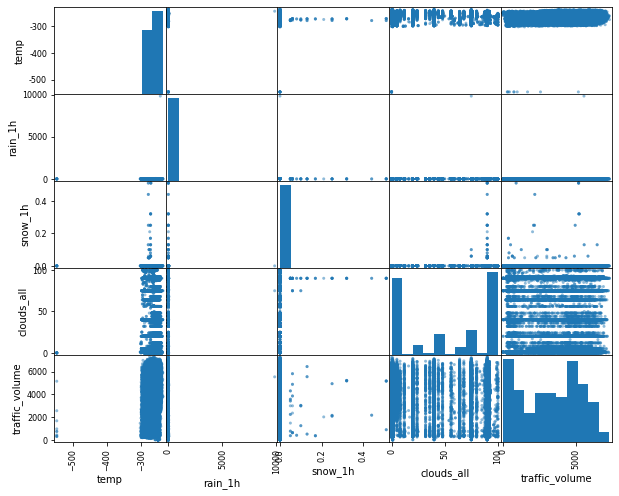

In [ ]:
num_vars = ['temp','rain_1h','snow_1h','clouds_all','traffic_volume']
scatter_matrix(df[num_vars],figsize=(10,8))
plt.show()

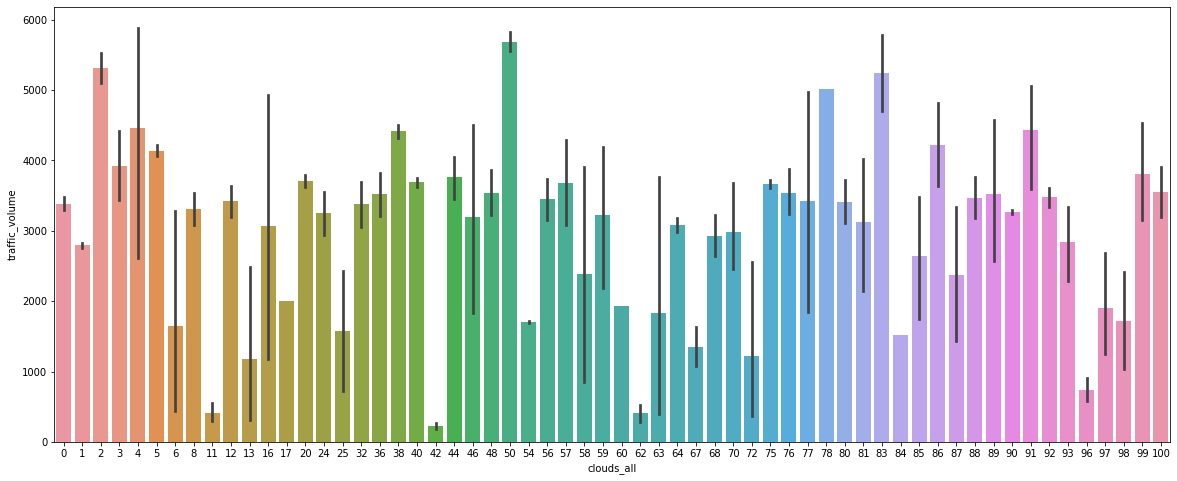

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='clouds_all', y = 'traffic_volume', data = df)
plt.show()

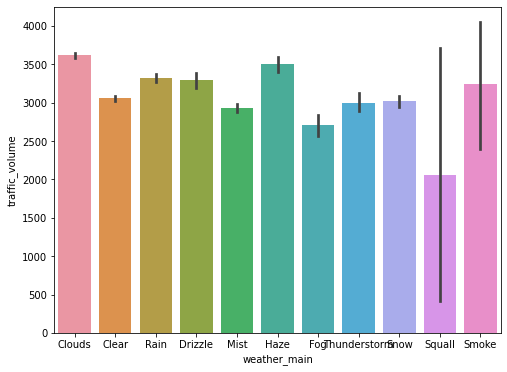

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='weather_main', y = 'traffic_volume', data = df)
plt.show()

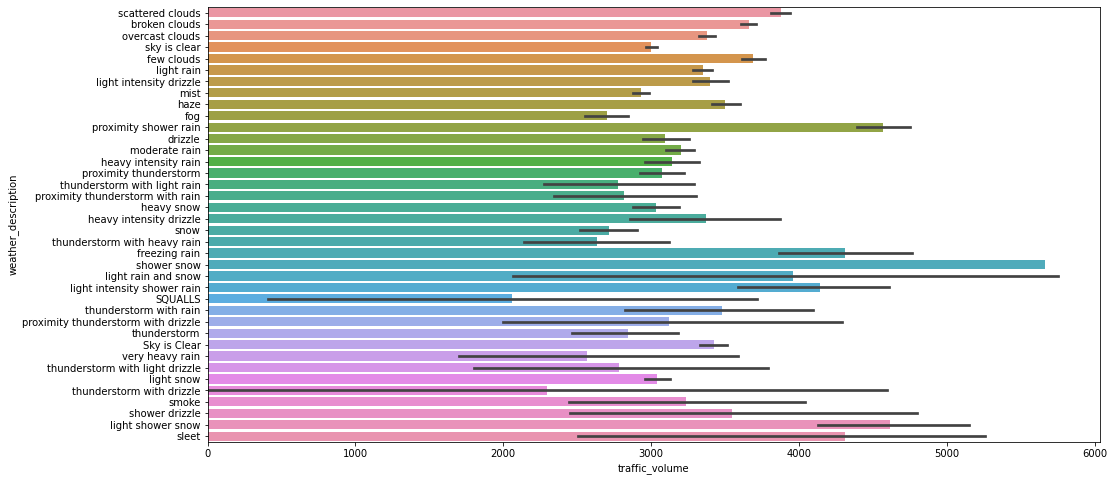

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(y='weather_description', x = 'traffic_volume', data = df)
plt.show()

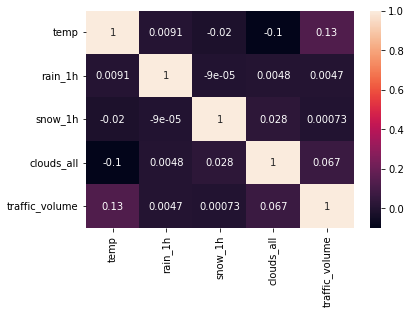

In [ ]:
sns.heatmap(df.corr(), annot=True)
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/corr.png')

# Data cleaning and Feature engineering

In [ ]:
features = df.copy()

In [ ]:
#Extracting features from date_time variable
features['date_time'] = pd.to_datetime(features.date_time)
features['weekday'] = features.date_time.dt.weekday
features['date'] = features.date_time.dt.date
features['hour'] = features.date_time.dt.hour
features['month'] = features.date_time.dt.month
features['year'] = features.date_time.dt.year
features.head()
#Monday is 0 and Sunday is 6

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,weekday,date,hour,month,year
0,None,-258.02,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,1,2012-10-02,9,10,2012
1,None,-256.94,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,1,2012-10-02,10,10,2012
2,None,-256.72,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,1,2012-10-02,11,10,2012
3,None,-256.17,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,1,2012-10-02,12,10,2012
4,None,-255.16,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,1,2012-10-02,13,10,2012


In [ ]:
def temporal_segment(x):
    early_morning = [4,5,6,7]
    morning = [8,9,10,11]
    afternoon = [12,13,14,15]
    evening = [16,17,18,19]
    night = [20,21,22,23]
    late_night = [24,1,2,3]
    if x in early_morning:
        return 'early_morning'
    elif x in morning:
        return 'morning'
    elif x in afternoon:
        return 'afternoon'
    elif x in evening:
        return 'evening'
    elif x in night:
        return 'night'
    else:
        return 'late_night'
    
features['time_of_day'] = features.hour.map(temporal_segment)

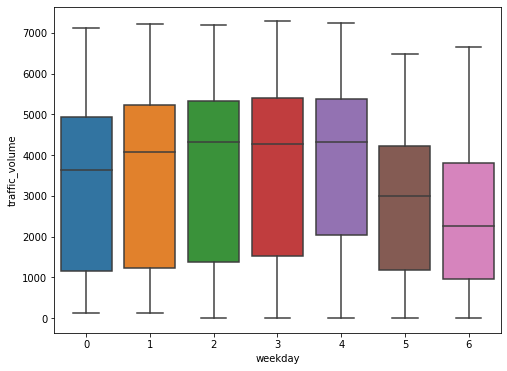

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='weekday', y='traffic_volume', data = features)
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/day_of_week_effect.png')

In [ ]:
yearly = features.groupby(['year']).aggregate({'traffic_volume':'mean'})
yearly = yearly.reset_index()

monthly = features.groupby(['month']).aggregate({'traffic_volume':'mean'})
monthly = monthly.reset_index()

hourly = features.groupby(['hour']).aggregate({'traffic_volume':'mean'})
hourly = hourly.reset_index()

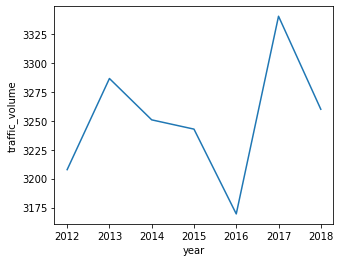

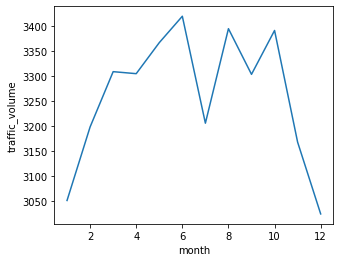

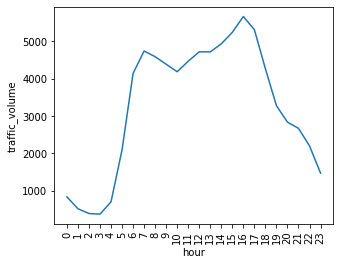

In [ ]:
plt.figure(figsize=(5,4))
sns.lineplot(x = yearly.year, y = yearly.traffic_volume,  data = yearly)
plt.show()

plt.figure(figsize=(5,4))
sns.lineplot(x = monthly.month, y = monthly.traffic_volume,  data = monthly)
plt.show()


plt.figure(figsize=(5,4))
ax=sns.lineplot(x = hourly.hour, y = hourly.traffic_volume,  data = hourly)
plt.xticks(np.arange(24), rotation=90)
plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/time_of_day.png')

In [ ]:
def modify_holiday(x):
    if x == 'None':
        return 'Work Day'
    else:
        return 'Holiday'
features['holiday'] = features['holiday'].map(modify_holiday)

In [ ]:
#Outlier in temp which was detected earlier needs to be removed
features = features.loc[features.temp>-250]

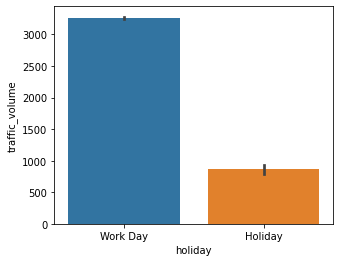

In [ ]:
#Traffic volume difference during holiday and non holiday
plt.figure(figsize=(5,4))
sns.barplot(x='holiday', y='traffic_volume', data = features)
plt.show()

In [ ]:
features.groupby('weather_description').aggregate({'traffic_volume':[np.mean,np.size],
                                                              'clouds_all':'count','rain_1h':'mean','snow_1h':'mean'})

traffic_volume         ...     rain_1h   snow_1h
                                              mean   size  ...        mean      mean
weather_description                                        ...                      
SQUALLS                                2061.750000      4  ...    3.482500  0.000000
Sky is Clear                           3423.148899   1726  ...    0.000000  0.000000
broken clouds                          3661.142092   4666  ...    0.000000  0.000000
drizzle                                3094.858679    651  ...    0.118710  0.000000
few clouds                             3691.453476   1956  ...    0.000000  0.000000
fog                                    2703.720395    912  ...    0.087007  0.000625
freezing rain                          4314.000000      2  ...    0.000000  0.000000
haze                                   3502.101471   1360  ...    0.046868  0.000000
heavy intensity drizzle                3371.109375     64  ...    0.170156  0.000000
heavy intensity rain                   3140.072805    467  ...    2.656660  0.000000
heavy snow                             3031.472403    616  ...    0.001234  0.000000
light intensity drizzle                3400.567273   1100  ...    0.180600  0.000000
light intensity shower rain            4140.307692     13  ...    0.333077  0.000000
light rain                             3349.257117   3372  ...    0.129404  0.000068
light rain and snow                    3961.166667      6  ...    0.211667  0.000000
light shower snow                      4618.636364     11  ...    0.000000  0.000000
light snow                             3042.770298   1946  ...    0.033320  0.001536
mist                                   2932.956639   5950  ...    0.238336  0.000728
moderate rain                          3202.603966   1664  ...    0.577843  0.000499
overcast clouds                        3375.963590   5081  ...    0.000000  0.000000
proximity shower rain                  4567.845588    136  ...    0.231838  0.000000
proximity thunderstorm                 3076.457652    673  ...    1.072897  0.000000
proximity thunderstorm with drizzle    3117.538462     13  ...    0.325385  0.000000
proximity thunderstorm with rain       2819.269231     52  ...    0.556923  0.000000
scattered clouds                       3875.622363   3461  ...    0.000000  0.000000
shower drizzle                         3547.666667      6  ...    0.000000  0.000000
shower snow                            5664.000000      1  ...    0.000000  0.000000
sky is clear                           3001.570510  11665  ...    0.000000  0.000000
sleet                                  4312.666667      3  ...    0.000000  0.000000
smoke                                  3237.650000     20  ...    0.527000  0.000000
snow                                   2712.122867    293  ...    0.019352  0.006041
thunderstorm                           2843.752000    125  ...    1.121440  0.000000
thunderstorm with drizzle              2297.000000      2  ...    5.345000  0.000000
thunderstorm with heavy rain           2631.142857     63  ...    3.071587  0.000000
thunderstorm with light drizzle        2779.266667     15  ...    2.014667  0.000000
thunderstorm with light rain           2776.833333     54  ...    0.684259  0.000000
thunderstorm with rain                 3476.405405     37  ...    1.699459  0.000000
very heavy rain                        2568.833333     18  ...  570.208333  0.000000

[38 rows x 5 columns]

In [ ]:
features['weather_description'] = features['weather_description'].map(lambda x:x.lower())

The weather description mostly describes rain, snow, thunderstorms, fog, mist and haze.

The following new columns will be created:
- thunderstorm - True where weather description contains Thunderstorm else False
- fog - True where weather description contains fog else False
- mist - True where weather description contains mist else False
- haze - True where weather description contains haze else False

In [ ]:
#Any row containing "thunderstorm" is replaced by "thunderstorm"
features.loc[features['weather_description'].str.contains('thunderstorm'),'weather_description'] = 'thunderstorm'    

In [ ]:
features.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,weekday,date,hour,month,year,time_of_day
0,Work Day,-258.02,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,1,2012-10-02,9,10,2012,morning
1,Work Day,-256.94,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,1,2012-10-02,10,10,2012,morning
2,Work Day,-256.72,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,1,2012-10-02,11,10,2012,morning
3,Work Day,-256.17,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,1,2012-10-02,12,10,2012,afternoon
4,Work Day,-255.16,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,1,2012-10-02,13,10,2012,afternoon
5,Work Day,-254.58,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181,1,2012-10-02,14,10,2012,afternoon
6,Work Day,-253.13,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584,1,2012-10-02,15,10,2012,afternoon
7,Work Day,-252.44,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015,1,2012-10-02,16,10,2012,evening
8,Work Day,-252.16,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791,1,2012-10-02,17,10,2012,evening
9,Work Day,-253.20,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770,1,2012-10-02,18,10,2012,evening


In [ ]:
# Changing weather description to 'other'
weather = ['thunderstorm','mist','fog','haze']
features.loc[np.logical_not(features['weather_description'].isin(weather)),'weather_description'] = 'other'

In [ ]:
features.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,weekday,date,hour,month,year,time_of_day
0,Work Day,-258.02,0.0,0.0,40,Clouds,other,2012-10-02 09:00:00,5545,1,2012-10-02,9,10,2012,morning
1,Work Day,-256.94,0.0,0.0,75,Clouds,other,2012-10-02 10:00:00,4516,1,2012-10-02,10,10,2012,morning
2,Work Day,-256.72,0.0,0.0,90,Clouds,other,2012-10-02 11:00:00,4767,1,2012-10-02,11,10,2012,morning
3,Work Day,-256.17,0.0,0.0,90,Clouds,other,2012-10-02 12:00:00,5026,1,2012-10-02,12,10,2012,afternoon
4,Work Day,-255.16,0.0,0.0,75,Clouds,other,2012-10-02 13:00:00,4918,1,2012-10-02,13,10,2012,afternoon
5,Work Day,-254.58,0.0,0.0,1,Clear,other,2012-10-02 14:00:00,5181,1,2012-10-02,14,10,2012,afternoon
6,Work Day,-253.13,0.0,0.0,1,Clear,other,2012-10-02 15:00:00,5584,1,2012-10-02,15,10,2012,afternoon
7,Work Day,-252.44,0.0,0.0,1,Clear,other,2012-10-02 16:00:00,6015,1,2012-10-02,16,10,2012,evening
8,Work Day,-252.16,0.0,0.0,20,Clouds,other,2012-10-02 17:00:00,5791,1,2012-10-02,17,10,2012,evening
9,Work Day,-253.20,0.0,0.0,20,Clouds,other,2012-10-02 18:00:00,4770,1,2012-10-02,18,10,2012,evening


In [ ]:
#creating dummy variables for these newly created categories in weather description
features = pd.get_dummies(columns=['weather_description'],data=features)

In [ ]:
features.rename(columns={'weather_description_fog':'fog', 'weather_description_haze':'haze',
                                   'weather_description_mist':'mist', 'weather_description_thunderstorm':'thunderstorm'}, inplace = True)
features.drop(columns = ['weather_description_other', 'weather_main'], inplace = True)

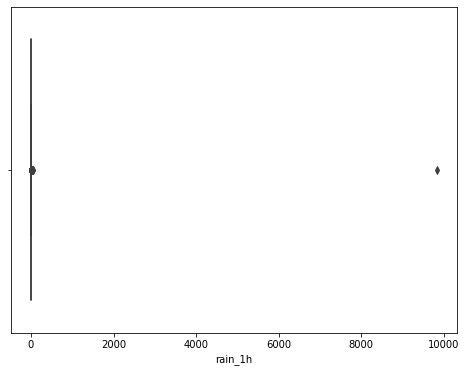

In [ ]:
#Ploting rain data shows one outlier data point. It will be removed.
plt.figure(figsize=(8,6))
sns.boxplot('rain_1h',data = features)
plt.show()

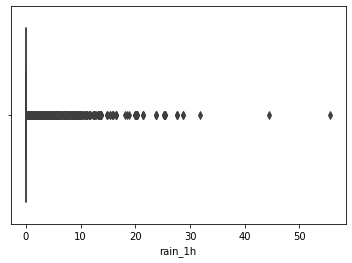

In [ ]:
sns.boxplot('rain_1h',data = features.loc[features.rain_1h<2000])

In [ ]:
#Removing outlier in rain column and converting numeric data to categories
#rain value equal to 0.0 as no_rain
#rain value greater than 0.0 is cut into 3 quantiles

features = features.loc[features['rain_1h']<2000]
features_temp = features.loc[features['rain_1h']>0]
rain_q = pd.DataFrame(pd.qcut(features_temp['rain_1h'] ,q=3, labels=['light','moderate','heavy']))


In [ ]:
features_merged = features.merge(rain_q,left_index=True, right_index=True, how='left')

features_merged['rain_1h_y'] = features_merged['rain_1h_y'].cat.add_categories('no_rain')
features_merged['rain_1h_y'].fillna('no_rain', inplace = True)

features_merged.drop(columns=['rain_1h_x'], inplace = True)
features_merged.rename(columns={'rain_1h_y':'rain_1h'}, inplace = True)
features_merged.head()

,holiday,temp,snow_1h,clouds_all,date_time,traffic_volume,weekday,date,hour,month,year,time_of_day,fog,haze,mist,thunderstorm,rain_1h
0,Work Day,-258.02,0.0,40,2012-10-02 09:00:00,5545,1,2012-10-02,9,10,2012,morning,0,0,0,0,no_rain
1,Work Day,-256.94,0.0,75,2012-10-02 10:00:00,4516,1,2012-10-02,10,10,2012,morning,0,0,0,0,no_rain
2,Work Day,-256.72,0.0,90,2012-10-02 11:00:00,4767,1,2012-10-02,11,10,2012,morning,0,0,0,0,no_rain
3,Work Day,-256.17,0.0,90,2012-10-02 12:00:00,5026,1,2012-10-02,12,10,2012,afternoon,0,0,0,0,no_rain
4,Work Day,-255.16,0.0,75,2012-10-02 13:00:00,4918,1,2012-10-02,13,10,2012,afternoon,0,0,0,0,no_rain


In [ ]:
features_merged['rain_1h'].unique()

['no_rain', 'light', 'moderate', 'heavy']
Categories (4, object): ['light' < 'moderate' < 'heavy' < 'no_rain']

In [ ]:
features_merged.head(5)

,holiday,temp,snow_1h,clouds_all,date_time,traffic_volume,weekday,date,hour,month,year,time_of_day,fog,haze,mist,thunderstorm,rain_1h
0,Work Day,-258.02,0.0,40,2012-10-02 09:00:00,5545,1,2012-10-02,9,10,2012,morning,0,0,0,0,no_rain
1,Work Day,-256.94,0.0,75,2012-10-02 10:00:00,4516,1,2012-10-02,10,10,2012,morning,0,0,0,0,no_rain
2,Work Day,-256.72,0.0,90,2012-10-02 11:00:00,4767,1,2012-10-02,11,10,2012,morning,0,0,0,0,no_rain
3,Work Day,-256.17,0.0,90,2012-10-02 12:00:00,5026,1,2012-10-02,12,10,2012,afternoon,0,0,0,0,no_rain
4,Work Day,-255.16,0.0,75,2012-10-02 13:00:00,4918,1,2012-10-02,13,10,2012,afternoon,0,0,0,0,no_rain


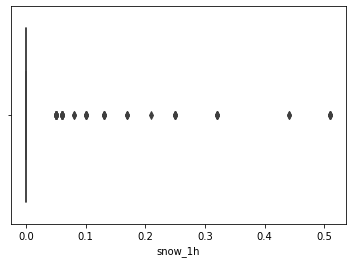

In [ ]:
sns.boxplot('snow_1h',data = features)

In [ ]:
features.snow_1h[features.snow_1h>0].count()

63

In [ ]:
def modify_snow1h(x):
    if x==0:
        return 'no_snow'
    else:
        return 'snow'
    
features_merged['snow_1h'] = features_merged['snow_1h'].map(modify_snow1h)

In [ ]:
features_merged.snow_1h

0        no_snow
1        no_snow
2        no_snow
3        no_snow
4        no_snow
          ...   
48199    no_snow
48200    no_snow
48201    no_snow
48202    no_snow
48203    no_snow
Name: snow_1h, Length: 48203, dtype: object

In [ ]:
features_merged.set_index('date', inplace = True)

In [ ]:
features_merged.head(5)

,holiday,temp,snow_1h,clouds_all,date_time,traffic_volume,weekday,hour,month,year,time_of_day,fog,haze,mist,thunderstorm,rain_1h
date,,,,,,,,,,,,,,,,
2012-10-02,Work Day,-258.02,no_snow,40,2012-10-02 09:00:00,5545,1,9,10,2012,morning,0,0,0,0,no_rain
2012-10-02,Work Day,-256.94,no_snow,75,2012-10-02 10:00:00,4516,1,10,10,2012,morning,0,0,0,0,no_rain
2012-10-02,Work Day,-256.72,no_snow,90,2012-10-02 11:00:00,4767,1,11,10,2012,morning,0,0,0,0,no_rain
2012-10-02,Work Day,-256.17,no_snow,90,2012-10-02 12:00:00,5026,1,12,10,2012,afternoon,0,0,0,0,no_rain
2012-10-02,Work Day,-255.16,no_snow,75,2012-10-02 13:00:00,4918,1,13,10,2012,afternoon,0,0,0,0,no_rain


In [ ]:
features_merged.shape

(48203, 16)

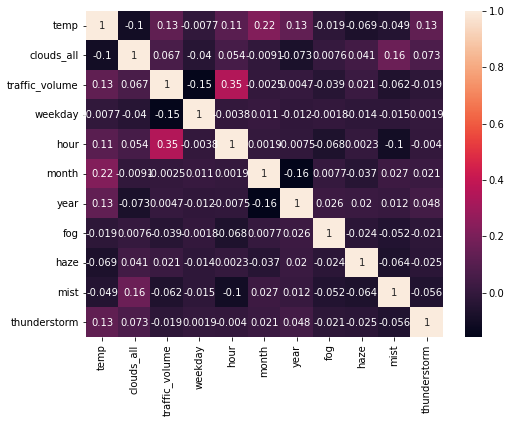

In [ ]:
plt.figure(figsize = (8,6))
sns.heatmap(features_merged.corr(), annot=True)
#plt.tight_layout()
#plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/after_corr.png')

In [ ]:
target = ['traffic_volume']
cat_vars = ['holiday', 'snow_1h','weekday', 'hour', 'month', 'year', 'fog', 'haze','mist', 'thunderstorm', 'rain_1h']
num_vars = ['temp','clouds_all']

# Data Preprocessing and normalization

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('oneHot',OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

df_traffic_transformed = preprocessor.fit_transform(features_merged).toarray()

In [ ]:
df_traffic_transformed.shape

(48203, 68)

In [ ]:
from sklearn.model_selection import train_test_split

#Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(df_traffic_transformed, features_merged['traffic_volume'], test_size=0.25, random_state = 42)

In [ ]:

'''
X_train = df_traffic_transformed[:32290]
X_test = df_traffic_transformed[32291:]
y_train = df_traffic_cat.traffic_volume[:32290]
y_test = df_traffic_cat.traffic_volume[32291:]
'''

In [ ]:
print("Training samples: ", X_train.shape)
print("Testing samples: ", X_test.shape)

Training samples:  (36152, 68)
Testing samples:  (12051, 68)


# Define and Train the Model

### Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rforest_model = RandomForestRegressor()
rforest_model = rforest_model.fit(X_train,y_train)

### Using XGBoost only

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror",  n_estimators=1000, random_state=42,n_jobs=-1)   # can use validation_fraction=0.2
xgb_model.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_test, y_test)], verbose = 0)

XGBRegressor(n_estimators=1000, n_jobs=-1, objective='reg:squarederror',
             random_state=42)

### Using XGBoost and GridSearch

In [ ]:
#Fitting XGBoost regressor and parameter tuning using Grid search
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


tscv = TimeSeriesSplit(n_splits=3)  # Time Series cross-validator, default split=5
model = xgb.XGBRegressor()
#n_estimators = range(100, 500, 100)

param_grid = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [0.001, 0.01],
              'max_depth': [5, 6],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [400, 1000]}
# n_estimators = The number of trees (or rounds) in an XGBoost model. Default is 100
# refit = an estimator using the best found parameters on the whole dataset, use inside GridSearchCV

GridSearch = GridSearchCV(estimator = model,param_grid= param_grid,cv=tscv, n_jobs = -1) #, scoring="neg_root_mean_squared_error"


In [ ]:
grid_result = GridSearch.fit(X_train, y_train, verbose=2)       

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.934829 using {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


# Evaluate and Prediction 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Random Forest

In [ ]:
y_train_pred_rforest = rforest_model.predict(X_train)
y_test_pred_rforest = rforest_model.predict(X_test)

accuracy_train_rforest = rforest_model.score(X_train, y_train)
accuracy_test_rforest = rforest_model.score(X_test, y_test)
mae_train_rforest = mean_absolute_error(y_train, y_train_pred_rforest)
mae_test_rforest = mean_absolute_error(y_test, y_test_pred_rforest)

print(f"R2 Score(train): {round(accuracy_train_rforest * 100, 3)}%")
print(f"R2 Score(test): {round(accuracy_test_rforest * 100, 3)}%\n")
print(f"Mean Absolute Error(train): {round(mae_train_rforest, 4)}")
print(f"Mean Absolute Error(test): {round(mae_test_rforest, 4)}\n")
print(f'RMSE(train): {round(np.sqrt(mean_squared_error(y_pred=y_train_pred_rforest,y_true=y_train)),4)}')
print(f'RMSE(test): {round(np.sqrt(mean_squared_error(y_pred=y_test_pred_rforest,y_true=y_test)),4)}')

R2 Score(train): 99.304%
R2 Score(test): 95.568%

Mean Absolute Error(train): 86.2938
Mean Absolute Error(test): 223.803

RMSE(train): 165.793
RMSE(test): 417.6811


### XGBoost

In [ ]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

accuracy_train_xgb = xgb_model.score(X_train, y_train)
accuracy_test_xgb = xgb_model.score(X_test, y_test)
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

print(f"R2 Score(train): {round(accuracy_train_xgb * 100, 3)}%")
print(f"R2 Score(test): {round(accuracy_test_xgb * 100, 3)}%\n")
print(f"Mean Absolute Error(train): {round(mae_train_xgb, 4)}")
print(f"Mean Absolute Error(test): {round(mae_test_xgb, 4)}\n")
print(f'RMSE(train): {round(np.sqrt(mean_squared_error(y_pred=y_train_pred_xgb,y_true=y_train)),4)}')
print(f'RMSE(test): {round(np.sqrt(mean_squared_error(y_pred=y_test_pred_xgb,y_true=y_test)),4)}')

R2 Score(train): 95.114%
R2 Score(test): 94.977%

Mean Absolute Error(train): 271.6201
Mean Absolute Error(test): 276.257

RMSE(train): 439.3997
RMSE(test): 444.6565


###XGBoost with GridSearch

In [ ]:
y_train_pred_xgb2 = GridSearch.predict(X_train)
y_test_pred_xgb2 = GridSearch.predict(X_test)

accuracy_train_xgb2 = GridSearch.score(X_train, y_train)
accuracy_test_xgb2 = GridSearch.score(X_test, y_test)
mae_train_xgb2 = mean_absolute_error(y_train, y_train_pred_xgb2)
mae_test_xgb2 = mean_absolute_error(y_test, y_test_pred_xgb2)

print(f"R2 Score(train): {round(accuracy_train_xgb2 * 100, 3)}%")
print(f"R2 Score(test): {round(accuracy_test_xgb2 * 100, 3)}%\n")
print(f"Mean Absolute Error(train): {round(mae_train_xgb2, 4)}")
print(f"Mean Absolute Error(test): {round(mae_test_xgb2, 4)}\n")
print(f'RMSE(train): {round(np.sqrt(mean_squared_error(y_pred=y_train_pred_xgb2,y_true=y_train)),4)}')
print(f'RMSE(test): {round(np.sqrt(mean_squared_error(y_pred=y_test_pred_xgb2,y_true=y_test)),4)}')

R2 Score(train): 94.147%
R2 Score(test): 94.133%

Mean Absolute Error(train): 315.829
Mean Absolute Error(test): 317.6943

RMSE(train): 480.8978
RMSE(test): 480.5609


# Plots

### Random Forest

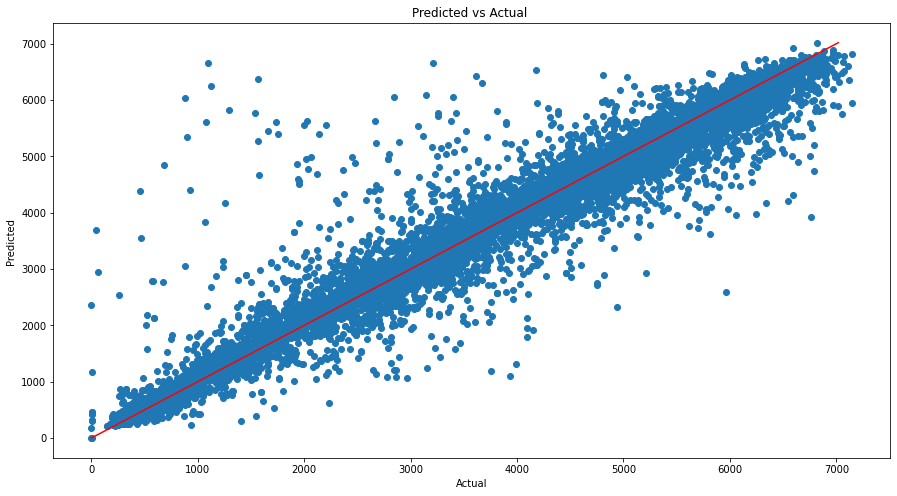

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter (y_test, y_test_pred_rforest) 
range = [y_test.min (), y_test_pred_rforest.max ()] 
plt.plot (range, range, 'red') 
plt.title('Predicted vs Actual ')
plt.xlabel ('Actual') 
plt.ylabel ('Predicted ') 
plt.show ()

###XGBoost

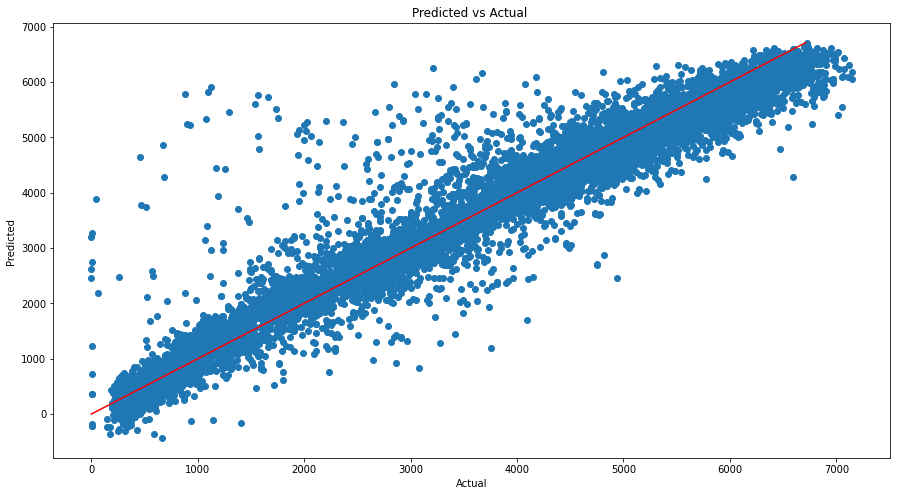

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter (y_test, y_test_pred_xgb) 
range = [y_test.min (), y_test_pred_xgb.max ()] 
plt.plot (range, range, 'red') 
plt.title('Predicted vs Actual ')
plt.xlabel ('Actual') 
plt.ylabel ('Predicted ') 
plt.show ()

###XGBoost with GridSearch

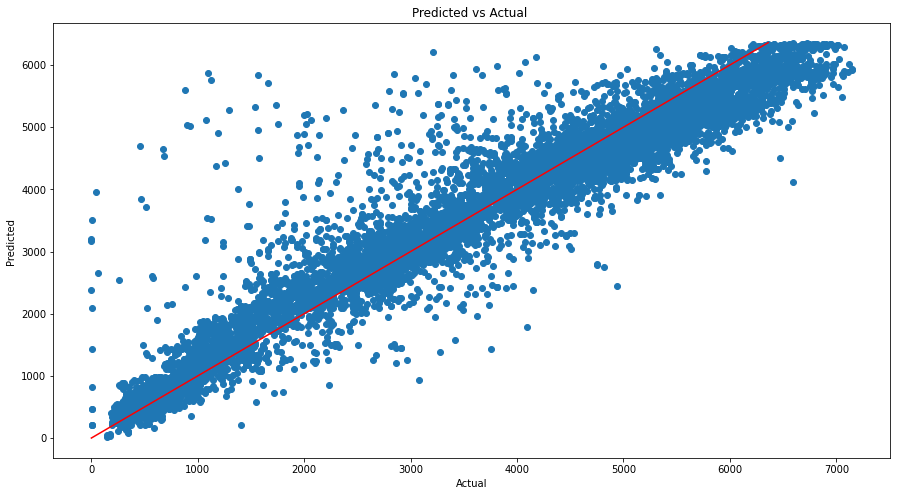

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter (y_test, y_test_pred_xgb2) 
range = [y_test.min (), y_test_pred_xgb2.max ()] 
plt.plot (range, range, 'red') 
plt.title('Predicted vs Actual ')
plt.xlabel ('Actual') 
plt.ylabel ('Predicted ') 
plt.show ()

# Deep Learning Models: LSTM

### Import Necessary modules

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GRU, SimpleRNN, LSTM
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Activation, Embedding, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

Max-normalization of numerical values

In [ ]:
features_merged['temp'] /= features_merged['temp'].max()
features_merged['traffic_volume'] /= features_merged['traffic_volume'].max()

Standardize data

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('oneHot',OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

df_traffic_transformed = preprocessor.fit_transform(features_merged).toarray()

#train-test split 
#train: 75%, test: 25%
X_train, X_test, y_train, y_test = train_test_split(df_traffic_transformed, features_merged['traffic_volume'], test_size=0.25, random_state = 42)

Prepare data for LSTM

In [128]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, y, look_back=1):
  dataX, dataY = [], []
  n = dataset.shape[0]-look_back-1
  for i in np.arange(n):
    a = dataset[i:(i+look_back)]
    dataX.append(a.tolist())
    dataY.append(y[i + look_back].tolist())
  return np.array(dataX), np.array(dataY)

# look at last 21 hours data and predict the next hour's traffic volume 
look_back = 21
trainX, trainY = create_dataset(X_train, y_train, look_back)
testX, testY = create_dataset(X_test, y_test, look_back)

## LSTM model

### Compile and fit

In [ ]:
model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=150, batch_size=64, validation_split=0.1, verbose=1)


# MLP model

In [ ]:
model = Sequential()
model.add(Dense(16, input_shape = (X_train.shape[1],)))    # Input layer => input_shape should be explicitly designated
model.add(Activation('sigmoid'))
#model.add(Dropout(0.1))

model.add(Dense(16))                         # Hidden layer => only output dimension should be designated
model.add(Activation('sigmoid'))
#model.add(Dropout(0.1))

model.add(Dense(8))                         # Hidden layer => only output dimension should be designated
model.add(Activation('sigmoid'))
#model.add(Dropout(0.1))

model.add(Dense(1))                          # Output layer => output dimension = 1 since it is regression problem
model.summary()

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history=model.fit(x=X_train, y=y_train,
          validation_split=0.1,
          batch_size=64,epochs=150)

### Plot training and validation loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss(MSE)')
plt.tight_layout()
plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/basic_MLP.png')

Save Model

In [135]:
#model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/basic_MLP')

INFO:tensorflow:Assets written to: ./basic_MLP/assets


## Evaluate models on test data

In [134]:
mlp_model = load_model('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/basic_MLP')
lstm_model = load_model('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/LSTM')

In [140]:
max_volume = features['traffic_volume'].max() 

def predict(testX, model):
  volume_pred = model.predict(testX)
  volume_pred *= max_volume
  return volume_pred

In [141]:
def plot_pred(y_test, volume_pred, n, fig_name):
  matplotlib.rcParams.update({'font.size': 14})
  plt.figure(figsize=(10,4))

  plt.plot(volume_pred)
  plt.plot(y_test)
  plt.xlabel('Hour')
  plt.ylabel('Traffic volume')
  plt.xticks(np.arange(0,n))

  plt.legend(['Forecasted', 'Observed'], loc = 'upper right')
  plt.title('Traffic volume forecast in test data')
  #plt.tight_layout()
  #plt.savefig('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Data Mining/Project/figs/'+fig_name)

### LSTM evaluation

In [ ]:
n = 20
testX, testY = create_dataset(X_test, y_test, look_back)
volume_pred = predict(testX, model=lstm_model)

plot_pred(y_test=y_test[:n].values*max_volume, volume_pred=volume_pred[:n].squeeze(), n=n, fig_name='LSTM_test_pred.png')

### MLP evaluation 

In [ ]:
n = 20
volume_pred = predict(X_test, model=mlp_model)
plot_pred(y_test=y_test[:n].values*max_volume, volume_pred=volume_pred[:n], n=n, fig_name='MLP_test_pred.png')